In [1]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
sample_rate = 500

In [4]:
signals = np.load("seg_signals.npy")
model = torch.jit.load("model.pt")
masks = model(torch.Tensor(signals).reshape(-1, 1, 5000))
masks = masks.argmax(axis=1).data.numpy()

In [5]:
# Вспомогательные функции, превращающие маску в сегментацию

v_to_del = {1:'p', 2:'qrs', 3:'t'}

def remove_small(signal):
    max_dist = 12
    last_zero = 0
    for i in range(len(signal)):
        if signal[i] == 0:
            if i - last_zero < max_dist:
                signal[last_zero:i] = 0
            last_zero = i

def merge_small(signal):
    max_dist = 12
    lasts = np.full(signal.max() + 1, -(max_dist+1))
    for i in range(len(signal)):
        m = signal[i]
        if i - lasts[m] < max_dist and m > 0:
            signal[lasts[m]:i] = m
        lasts[m] = i

def mask_to_delineation(mask):
    merge_small(mask)
    remove_small(mask)
    delineation = {'p':[], 'qrs':[], 't':[]}
    i = 0
    mask_length = len(mask)
    while i < mask_length:
        v = mask[i]
        if v > 0:
            delineation[v_to_del[v]].append([i, 0])
            while i < mask_length and mask[i] == v:
                delineation[v_to_del[v]][-1][1] = i
                i += 1
            t = delineation[v_to_del[v]][-1]
        i += 1
    return delineation


In [18]:
wave_type_to_color = {
    "p": "yellow",
    "qrs": "red",
    "t": "green"
}

def plot_signal_with_mask(signal, mask):
    plt.figure(figsize=(18, 5))
    plt.title("Сигнал с маской")
    plt.xlabel("Время (сек)")
    plt.ylabel("Амплитуда (мВ)")
    x_axis_values = np.linspace(0, len(signal) / sample_rate, len(signal))
    plt.plot(x_axis_values, signal, linewidth=2, color="black")
    
    delineation = mask_to_delineation(mask)
    print(delineation)
    for wave_type in ["p", "qrs", "t"]:
        color = wave_type_to_color[wave_type]
        for begin, end in delineation[wave_type]:
            begin /= sample_rate
            end /= sample_rate
            plt.axvspan(begin, end, facecolor=color, alpha=0.5)

{'p': [[174, 244], [582, 597], [793, 845], [1131, 1186], [1502, 1555], [1869, 1921], [2246, 2297], [2612, 2664], [3004, 3055], [3426, 3481], [3878, 3925], [4262, 4311], [4489, 4526], [4623, 4695], [4738, 4864], [4950, 4968], [4994, 4999]], 'qrs': [[864, 910], [1203, 1248], [1572, 1615], [1939, 1983], [2315, 2359], [2682, 2726], [3074, 3117], [3497, 3541], [3941, 3985], [4328, 4373]], 't': [[616, 714], [950, 1046], [1290, 1382], [1659, 1751], [2032, 2121], [2399, 2497], [2772, 2862], [3159, 3258], [3584, 3682], [4030, 4124], [4417, 4487]]}


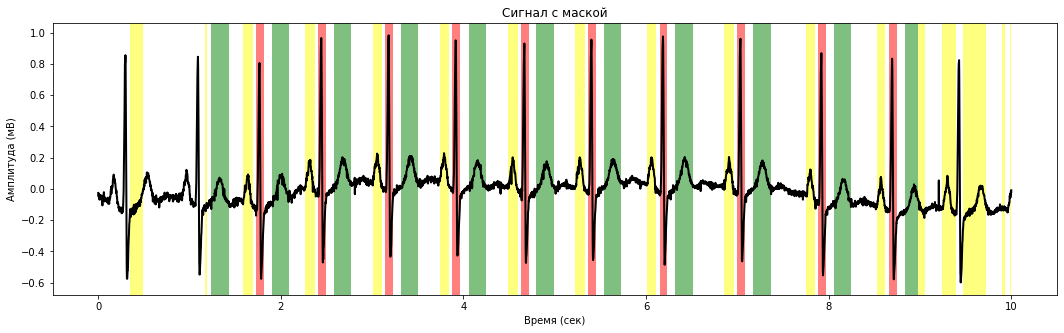

In [19]:
index = 3
plot_signal_with_mask(signals[index], masks[index])